In [3]:
include("../analysis/mESC/load_analysis.jl");

/home/augustinas/CellCycle-RNAseq/analysis/mESC
Julia Version 1.9.3
Commit bed2cd540a1 (2023-08-24 14:43 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 20 × Intel(R) Xeon(R) Silver 4114 CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, skylake-avx512)
  Threads: 9 on 20 virtual cores
Environment:
  JULIA_NUM_THREADS = 8

1333 cells in G1
2240 cells in S
2113 cells in G2M
Cut off 392 cells in G1
Considering 3882 genes out of 11544 in total
3054 cells in the merged (G1 + G2M) dataset
Shared genes: 1669


In [88]:
median(means_ratio)

1.3965905514539145

# Fig. 2A: Mean expression

In [4]:
means_G1 = mean.(xG1)
means_G2M = mean.(xG2M)
means_ratio = means_G2M ./ means_G1;

In [5]:
median(means_ratio)

1.3965905514539145

In [6]:
quantile(means_ratio, 0.25)

1.2935422419275322

In [7]:
quantile(means_ratio, 0.75)

1.4835035545445754

In [8]:
function stairpts(s)
    pts = s.plots[1].converted[1][]
    [p[1] for p in pts], [p[2] for p in pts]
end

stairpts (generic function with 1 method)

In [20]:
f = Figure(resolution = (size_pt[1]*0.9, size_pt[2]*0.9), figure_padding = 1)
ax = Axis(f[1,1], xlabel="Ratio of means Λ", ylabel="Probability")

rmax = ceil(maximum(means_ratio), digits=1)
dr = 0.05
rs = 0:dr:rmax
ws = fit(Histogram, means_ratio, vcat(rs, rmax+dr), closed=:right)
ws = normalize(ws, mode=:probability)
ws = ProbabilityWeights(ws.weights)

ylims!(0, nothing)
xlims!(0.5, 2.5)

s = stairs!(ax, rs, ws, step=:post, color=(c1, 1), linewidth=0)

xs′, ys′ = stairpts(s)
band!(ax, xs′, 0*ys′, ys′, color=(c1, 1), label="Data")
vlines!(ax, 1, linewidth=1, color=(c3, 1), linestyle=:dash)
vlines!(ax, 2, linewidth=1, color=(c3, 1), linestyle=:dash)

Combined{Makie.vlines, Tuple{Int64}}

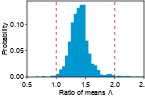

In [21]:
f

In [11]:
#save("../data/mESC/figures/2A_ratio_means.pdf", f, pt_per_unit = 1);

# Fig. 2B: Cartoon

In [22]:
function plot_fit_new(f::GridPosition, xdata::AbstractArray, d::Distribution, nconv::Int; kwargs...)
    ax = Axis(f, 
          xlabel="Counts", ylabel="Probability", kwargs...)
    xs, ww = fit_hist(xdata)
    ww = ww ./ ww.sum
    
    ylims!(0, nothing)
    xlims!(-0.8, xs[end]+0.8)
    
    s = stairs!(ax, vcat(-1, xs, xs[end]+1), vcat(0, ww, 0), 
               step=:center, color=(c1, 1), linewidth=0)

    xs′, ys′ = stairpts(s)
    band!(ax, xs′, 0*ys′, ys′, color=(colorant"#d0d0d1", 1), label="Data")
    vlines!(ax, mean(xdata), linewidth=1, color=(c3, 0.8))
    lines!(ax, xs, convn(pdf.(d, xs), nconv), markersize=2, color=(c1, 1), linewidth=1, label="MLE fit")
    ax
end

function plot_fit_new(xdata::AbstractArray, d::Distribution, nconv::Int; kwargs...)
    f = Figure(resolution = (size_pt[1]*0.65, size_pt[2]*0.7), figure_padding = 3)
    plot_fit_new(f[1,1], xdata, d, nconv, kwargs...)
    f
end

plot_fit_new (generic function with 2 methods)

In [23]:
ind = findfirst(gene_names .== "Nme1")

234

In [26]:
d = G1_th_ind_fits[ind]
x = thetaG1
nconv=2
y = xG1[ind];

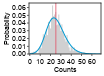

In [27]:
plot_fit_new(y, d, nconv)

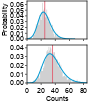

In [28]:
f = Figure(resolution = (size_pt[1]*0.55, size_pt[2]*0.95), figure_padding = 1)
ga = f[1,1] = GridLayout()

xlim = 85
y = xG1[ind]
nconv = 2
d = G1_th_ind_fits[ind]

ax1 = plot_fit_new(ga[1,1], y, d, nconv)
ax1.xlabel = ""
ax1.xticklabelsvisible = false
xlims!(ax1, (0, xlim))

y = xG2M[ind]
nconv=4
d = G2M_th_ind_fits[ind]

ax2 = plot_fit_new(ga[2,1], y, d, nconv)
ax2.ylabel = ""
xlims!(ax2, (0, xlim))

rowgap!(ga, 5)

f

In [305]:
#save("../data/mESC/figures/2B_dists.pdf", f, pt_per_unit = 1);

# Fig. 2C: example ratios + CIs

In [29]:
burst_freqs_G1_th_ind = get_burst_frequency.(G1_th_ind_fits)
burst_freqs_G2M_th_ind = get_burst_frequency.(G2M_th_ind_fits);

In [30]:
burst_sizes_G1_th_ind = get_burst_size.(G1_th_ind_fits)
burst_sizes_G2M_th_ind = get_burst_size.(G2M_th_ind_fits);

In [31]:
ratio_f = burst_freqs_G2M_th_ind ./ burst_freqs_G1_th_ind
ratio_b = burst_sizes_G2M_th_ind ./ burst_sizes_G1_th_ind;

In [32]:
genes = ["Avpi1", "Rpl7", "Akap9", "Smc1a", "Cobl"]
inds = [findfirst(gene_names .== gene) for gene in genes];

In [33]:
println(means_ratio[inds])

[1.0953490721166343, 1.4388463591435858, 1.8548536374494726, 2.015238708826606, 2.0691925225669094]


In [34]:
CI_ratio_f = @time get_ratio_confidence_intervals(G1_th_ind_fits[inds], xG1[inds], nothing, 2,
                                                  G2M_th_ind_fits[inds], xG2M[inds], nothing, 4,
                                                  get_burst_frequency_ratio_CI_PL, time_limit=60.0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

 13.089820 seconds (18.31 M allocations: 1.163 GiB, 0.68% gc time, 533.11% compilation time: <1% of which was recompilation)


5-element Vector{Tuple}:
 (0.5842649962690709, 0.9079298797457824)
 (0.4413265488253395, 0.5756917930024642)
 (0.701827944432258, 1.1954445371645661)
 (0.6396274202091051, 0.9938116553626134)
 (0.34654919142101653, 0.6208958549942979)

In [35]:
CI_ratio_b = @time get_ratio_confidence_intervals(G1_th_ind_fits[inds], xG1[inds], nothing, 2,
                                                  G2M_th_ind_fits[inds], xG2M[inds], nothing, 4,
                                                  get_burst_size_ratio_CI_PL, time_limit=60.0)

  5.798463 seconds (6.40 M allocations: 436.174 MiB, 3.96% gc time, 452.32% compilation time)


5-element Vector{Tuple}:
 (0.5998992294774101, 0.9420077285705533)
 (1.2473937679233336, 1.6328637418765692)
 (0.7686618930582618, 1.331672437767832)
 (1.0093895077371076, 1.5809239386413045)
 (1.658383441206064, 2.9953347481871293)

In [44]:
f = Figure(resolution = (size_pt[1]*0.9, size_pt[2]*1.35), figure_padding = 1)
ga = f[1,1] = GridLayout()

ax = Axis(ga[1,1],
          xlabel="", ylabel="Burst frequency ratio", xticklabelsvisible=false)
x = 1:length(genes)
ax.xticks = (x, genes)

y = ratio_f[inds]
y_lb = first.(CI_ratio_f)
y_ub = last.(CI_ratio_f)
scatter!(ax, x, y, markersize=7, color=c2)
errorbars!(ax, x, y, y .- y_lb, y_ub .- y, whiskerwidth=5, color=c2)
hlines!(ax, 1, color=(:black, 0.5), linestyle=:dash)
ylims!(ax, (0.3, 1.4))

ax = Axis(ga[2,1],
          xlabel="", ylabel="Burst size ratio")
x = 1:length(genes)
ax.xticks = (x, genes)

y = ratio_b[inds]
y_lb = first.(CI_ratio_b)
y_ub = last.(CI_ratio_b)
scatter!(ax, x, y, markersize=7, color=c1)
errorbars!(ax, x, y, y .- y_lb, y_ub .- y, whiskerwidth=5, color=c1)
hlines!(ax, 1, color=(:black, 0.5), linestyle=:dash)

rowgap!(ga, 3)

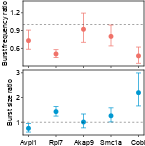

In [45]:
f

In [161]:
#save("../data/mESC/figures/2C_CI_ratios.pdf", f, pt_per_unit = 1);

# Fig. 2D: raincloud plots of ratios

In [40]:
@show median(ratio_f)
@show quantile(ratio_f, 0.25)
@show quantile(ratio_f, 0.75);

median(ratio_f) = 0.492319793475726
quantile(ratio_f, 0.25) = 0.43913474603251196
quantile(ratio_f, 0.75) = 0.5581227774346554


In [41]:
@show median(ratio_b)
@show quantile(ratio_b, 0.25)
@show quantile(ratio_b, 0.75);

median(ratio_b) = 1.4191079621607672
quantile(ratio_b, 0.25) = 1.2354794030398588
quantile(ratio_b, 0.75) = 1.598217787535615


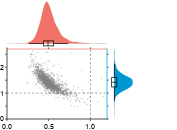

In [42]:
x = ratio_f
y = ratio_b
f = Figure(resolution = (size_pt[1]*1.1, size_pt[2]*1.2), figure_padding = 1)

ga = f[1, 1] = GridLayout()
axtop = Axis(ga[1, 1], 
             leftspinevisible = false,
             rightspinevisible = false,
             bottomspinevisible = false,
             topspinevisible = false)
axmain = Axis(ga[2, 1], xlabel = "", ylabel = "",
              yminorticks = IntervalsBetween(2),
              yminorticksvisible = true,
              yminorticksize = 1.5,
              yminortickwidth = 0.7,
              xticksmirrored = true,
              yticksmirrored = true,
              rightspinecolor = (c1, 1),
              topspinecolor = (c2, 1))
axright = Axis(ga[2, 2],
               leftspinevisible = false,
               rightspinevisible = false,
               bottomspinevisible = false,
               topspinevisible = false)

linkyaxes!(axmain, axright)
linkxaxes!(axmain, axtop)

hidedecorations!(axtop, grid = false)
hidedecorations!(axright, grid = false)
scatter!(axmain, x, y, color=(:gray, 0.4), markersize=2)
vlines!(axmain, 1, color=(:black, 0.5), linestyle=:dash)
hlines!(axmain, 1, color=(:black, 0.5), linestyle=:dash)
xlims!(axmain, low = 0, high = 1.2)

density!(axtop, x, color=(c2))
hlines!(axtop, 0, color=(:black, 0.3), linewidth=0.3)
boxplot!(axtop, fill(0.0, length(x)), x, orientation=:horizontal, strokewidth = 0.7, 
         width=0.7, whiskerwidth=0, show_outliers=false, color=(c2, 0))
ylims!(axtop, low=-0.4, high=4.7)

density!(axright, y, direction = :y, color=(c1))
vlines!(axright, 0, color=(:black, 0.3), linewidth=0.3)
boxplot!(axright, fill(0.0, length(y)), y, strokewidth = 0.7, 
         width=0.5, whiskerwidth=0, show_outliers=false, color=(c1, 0))
ylims!(axright, low = 0, high = 2.7)
xlims!(axright, low=-0.4, high=4.7)

colgap!(ga, 2)
rowgap!(ga, 2)
colsize!(ga, 2, Relative(1.2/3))
rowsize!(ga, 1, Relative(1.2/3))

f

In [1094]:
#save("../data/mESC/figures/2D_plot.pdf", f, pt_per_unit = 1);

# Fig. 2e: relative change

Computed as $\left(f_{\text{G2/M}} - f_{\text{G1}}\right) / f_{\text{G1}}$ and similarly for burst size.

In [18]:
Δf = @. abs(burst_freqs_G2M_Vind - burst_freqs_G1_Vind) / burst_freqs_G1_Vind
Δb = @. abs(burst_sizes_G2M_Vind - burst_sizes_G1_Vind) / burst_sizes_G1_Vind;

In [47]:
function get_relative_change_ratio_CI_PL(d1::DiscreteUnivariateDistribution, y1::AbstractArray, theta1, nconv1::Int,
                                         d2::DiscreteUnivariateDistribution, y2::AbstractArray, theta2, nconv2::Int; 
                                         resolution::Int=1000, alpha::Float64=0.05, kwargs...)
    
    # Profile likelihood set up such that Q_Δ = [(f₂-f₁) / f₁] / [(bs₂-bs₁) / bs₁] ⟹ f₂ = Q_Δ × f₁ × (bs₂ - bs₁) / bs₁ + f₁
    # We vary Δ and maximise the joint likelihood where f₂ is fixed

    loss_joint, n1, n2, xs, lb, ub, tau = init_ratio_CI_PL(d1, y1, theta1, nconv1, 
                                                           d2, y2, theta2, nconv2, alpha)
    loss_MLE = loss_joint(xs)

    p_lb = -100; p_ub = 100 # fixed Δ bounds in the real-space
    f_i1 = bf_ind(d1)
    f_i2 = bf_ind(d2)
    b_i1 = b_ind(d1)
    b_i2 = b_ind(d2)
    lb[f_i2] = p_lb; ub[f_i2] = p_ub
    dstep = (p_ub - p_lb)/resolution 

    bs1 = get_burst_size(d1, theta1)
    bs2 = get_burst_size(d2, theta2)
    Δb = (bs2 - bs1) / bs1

    bf1 = get_burst_frequency(d1)
    bf2 = get_burst_frequency(d2)
    Δf = (bf2 - bf1) / bf1

    Q_Δ = Δf / Δb
    xs[f_i2] = Q_Δ
    fn = identity
    log_wsum_fth1 = get_log_weighted_sum_ftheta(d1, theta1)
    log_wsum_fth2 = get_log_weighted_sum_ftheta(d2, theta2)
    log_b1 = get_log_b(d1)
    log_b2 = get_log_b(d2)
    
    function log_bs1(x)
        x1 = @view x[n2+1:end]
        log_b1(x1) + log_wsum_fth1(x1)
    end

    function log_bs2(x)
        x2 = @view x[1:n2]
        log_b2(x2) + log_wsum_fth2(x2)
    end

    function term(x)
        _Q = x[f_i2]
        lb1 = log_bs1(x)
        lb2 = log_bs2(x)
        _term = 1 + _Q * (exp(lb2-lb1) - 1)
        return _term
    end
    
    log_bf2(x) = NaNMath.log(term(x)) + x[n2+f_i1] - isNB(d1)*log(nconv1) + isNB(d2)*log(nconv2)
    
    # shift the parameters so that Δ is the first argument to the loss function
    n = n1+n2
    _inds = circshift(1:n, n-f_i2+1)
    srt_inds = sortperm(_inds)

    function lossf(x)
        _f2 = log_bf2(x[srt_inds])
        if isnan(_f2)
            return NaN
        else
            loss_joint(vcat(_f2, x[2:end])[srt_inds])
        end
    end
    
    lossf(x2, p) = lossf(vcat(p, x2))
    _lb = vcat(lb[_inds], 0)
    _ub = vcat(ub[_inds], Inf)
    cons(res, x2, p) = (res .= vcat(x2, term(vcat(p, x2)[srt_inds])))
    runf(_dstep) = profile_likelihood_CI(lossf, loss_MLE, xs[_inds], _dstep, tau, fn, _lb, _ub, cons; kwargs...)
    
    p_lower = runf(-dstep)
    p_upper = runf(dstep)
    Δ_lb = fn(p_lower)
    Δ_ub = fn(p_upper)    
    Δ_lb, Δ_ub
    
end


get_relative_change_ratio_CI_PL (generic function with 1 method)

In [48]:
function abs_bounds(x)
    lb, ub = x
    if lb < 0 && ub < 0
        return (abs(ub), abs(lb))
    elseif lb < 0 && ub >= 0
        return (0, max(abs(lb), ub))
    elseif lb >=0 && ub >= 0
        return (lb, ub) 
    end
    error("faulty CI bounds")
end

abs_bounds (generic function with 1 method)

In [49]:
# compile
inds = 1:10
@time all_CI_Q_Δ = get_ratio_confidence_intervals(G1_th_ind_fits[inds], xG1[inds], nothing, 2,
                                                  G2M_th_ind_fits[inds], xG2M[inds], nothing, 4,
                                                  get_relative_change_ratio_CI_PL, time_limit=10.0);

ind 6: ErrorException("Optimiser took too long:\n\n1.753396987915039 s")
ind 3: ErrorException("Optimiser took too long:\n\n1.7545080184936523 s")
ind 8: ErrorException("Optimiser took too long:\n\n1.805927038192749 s")
ind 7: ErrorException("Optimiser took too long:\n\n3.037515878677368 s")
ind 5: ErrorException("Optimiser took too long:\n\n2.0154662132263184 s")
ind 9: ErrorException("Optimiser took too long:\n\n1.99043607711792 s")
ind 10: ErrorException("Optimiser took too long:\n\n1.7910780906677246 s")
ind 1: ErrorException("Optimiser took too long:\n\n3.6980960369110107 s")
  6.379146 seconds (8.22 M allocations: 552.901 MiB, 687.47% compilation time)


In [52]:
inds = 1:ngenes
@time all_CI_Q_Δ = get_ratio_confidence_intervals(G1_th_ind_fits[inds], xG1[inds], nothing, 2,
                                                  G2M_th_ind_fits[inds], xG2M[inds], nothing, 4,
                                                  get_relative_change_ratio_CI_PL, time_limit=10.0);

ind 2: ErrorException("Optimiser took too long:\n\n6.979435920715332 s")
ind 1051: ErrorException("Optimiser took too long:\n\n5.733087062835693 s")
ind 1257: ErrorException("Optimiser took too long:\n\n13.842172861099243 s")
ind 1260: ErrorException("Optimiser took too long:\n\n19.346954107284546 s")
ind 221: ErrorException("Optimiser took too long:\n\n18.482904195785522 s")
ind 228: ErrorException("Optimiser took too long:\n\n18.012742042541504 s")
ind 1279: ErrorException("Optimiser took too long:\n\n7.219874858856201 s")
ind 1284: ErrorException("Optimiser took too long:\n\n27.954010009765625 s")
ind 1090: ErrorException("Optimiser took too long:\n\n30.053568124771118 s")
ind 36: ErrorException("Optimiser took too long:\n\n44.93226408958435 s")
ind 1304: ErrorException("Optimiser took too long:\n\n40.71086311340332 s")
ind 261: ErrorException("Optimiser took too long:\n\n39.08150315284729 s")
ind 902: ErrorException("Optimiser took too long:\n\n45.047630071640015 s")
ind 57: ErrorE

In [53]:
inds = findall(!isassigned(all_CI_Q_Δ, i) for i in 1:ngenes)
@time all_CI_Q_Δ[inds] = get_ratio_confidence_intervals(G1_th_ind_fits[inds], xG1[inds], nothing, 2,
                                                        G2M_th_ind_fits[inds], xG2M[inds], nothing, 4,
                                                        get_relative_change_ratio_CI_PL, time_limit=100.0);

152.942556 seconds (48.41 M allocations: 48.580 GiB, 2.23% gc time, 0.03% compilation time)


In [54]:
abs_CI_Q_Δ = abs_bounds.(all_CI_Q_Δ);

In [56]:
# burst frequency change clearly greater than burst size change
inds1 = findall(first.(abs_CI_Q_Δ) .> 1)
per1 = length(inds1) / ngenes * 100
@show length(inds1)
@show per1
# burst size change clearly greater than burst frequency change
inds2 = findall(last.(abs_CI_Q_Δ) .< 1)
per2 = length(inds2) / ngenes * 100
@show length(inds2)
@show per2
# burst size change is similar to that of burst frequency
inds3 = findall(first.(abs_CI_Q_Δ) .<= 1)
inds4 = findall(last.(abs_CI_Q_Δ) .>= 1)
inds5 = intersect(inds3, inds4) 
per3 = length(inds5) / ngenes * 100
@show length(inds5)
@show per3;

length(inds1) = 268
per1 = 16.057519472738164
length(inds2) = 89
per2 = 5.3325344517675255
length(inds5) = 1312
per3 = 78.6099460754943


In [57]:
Λ₁ = means_ratio[inds5]
Λ₂ = means_ratio[inds2]
Λ₃ = means_ratio[inds1];

In [61]:
@show median(Λ₁)
@show quantile(Λ₁, 0.25)
@show quantile(Λ₁, 0.75);

median(Λ₁) = 1.409795257502403
quantile(Λ₁, 0.25) = 1.3130777483799672
quantile(Λ₁, 0.75) = 1.4874638902332564


In [62]:
@show median(Λ₂)
@show quantile(Λ₂, 0.25)
@show quantile(Λ₂, 0.75);

median(Λ₂) = 1.591837657667485
quantile(Λ₂, 0.25) = 1.4742556002524057
quantile(Λ₂, 0.75) = 1.9500789686303008


In [63]:
@show median(Λ₃)
@show quantile(Λ₃, 0.25)
@show quantile(Λ₃, 0.75);

median(Λ₃) = 1.2914722652574313
quantile(Λ₃, 0.25) = 1.2048933200496283
quantile(Λ₃, 0.75) = 1.3701041797376319


In [64]:
median(Λ₂) > median(Λ₁) > median(Λ₃)

true

In [66]:
cx1 = colorant"#8790fd"
cx2 = colorant"#0098D1"
cx3 = colorant"#f07269";

In [67]:
f = Figure(resolution = (size_pt[1]*0.9, size_pt[2]*1.1), figure_padding = 2)

ax = Axis(f[1, 1],
          ylabel="Percentage of cells",
          yscale=log10,
          yminorticksvisible = true,
          yminorticksize = 1.5,
          yminortickwidth = 0.7,
          yminorticks = IntervalsBetween(9),
          yticks = ([1, 10, 100]),
          xticks=(1:3, ["|Δf| ≈ |Δb|", "|Δf| < |Δb|", "|Δf| > |Δb|"]))

barplot!(ax, [1, 2, 3], [per3, per2, per1], color=[cx1, cx2, cx3], gap=0.0, width=0.85, direction=:y, fillto=1.0)
ylims!(ax, low=1, high=130)

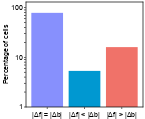

In [68]:
f

In [2164]:
#save("../data/mESC/figures/2E_relchange.pdf", f, pt_per_unit = 1);